In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly import express as px
import cufflinks
cufflinks.go_offline()

import pickle
from scipy import sparse

import sys
sys.path.append('../src/sankey/')

from utils import *

#############################################

from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
from collections import Counter
import ipywidgets as widgets

# LOAD DATA

In [39]:
with open('../data/processed/inn_list.pkl', 'rb') as f:
    inn_list = pickle.load(f)
    
with open('../data/processed/inn_dict.pkl', 'rb') as f:
    inn_dict = pickle.load(f)
    
transactions_matrix = sparse.load_npz('../data/processed/transactions.npz')

inn_info = pd.read_parquet('../data/processed/inn_info.parquet')
df = pd.read_parquet('../data/processed/gibdd.parquet')

In [43]:
inn_info.sample(10)

,region,department
inn,,
1657124452,Татарстан,Лесная
1435007236,Якутия,Коммерческие перевозки
6671376845,Свердловская область,Лизинговая компания
6727024439,Смоленская область,Сельское хозяйство
3325013255,Владимирская область,None
7453251929,Челябинская область,None
6452037720,Саратовская область,Энергетическая
1655319880,Татарстан,Строительная
7105500035,Тульская область,Строительная


# PREPARATION

## SELECT INN

In [189]:
# inn_seller = inn_info.sample(5_000).index.tolist()
inn_seller = inn_info.loc[inn_info['region'] == 'Москва'].index.tolist()
inn_buyer = inn_info.loc[inn_info['region'] == 'Татарстан'].index.tolist()

In [105]:
vin_tr = df.query('brand == "КАМАЗ"').query('model == "5490"')['vin'].unique()

In [83]:
inn_buyer = inn_info.loc[inn_info['region'] == 'Татарстан'].index.tolist()

## INN ENRICHMENT

In [190]:
inn_seller = intersection(inn_seller, inn_list)
inn_buyer = intersection(inn_buyer, inn_list)

# Seller enrichment
index_seller = inn_info.loc[inn_seller]
index_seller = index_seller.set_index(['region', 'department'], append=True)

# Buyer enrichment
index_buyer = inn_info.loc[inn_buyer]
index_buyer = index_buyer.set_index(['region', 'department'], append=True)

## CREATE TRANSACTION MATRIX

In [85]:
%%time

transaction_subsample = transaction_dataframe(inn_seller, inn_buyer, transactions_matrix, inn_dict)
transaction_subsample.index = index_seller.index
transaction_subsample.columns = index_buyer.index

CPU times: user 33.3 ms, sys: 48.8 ms, total: 82.1 ms
Wall time: 80.7 ms


In [86]:
filter_zeros(transaction_subsample)

,,inn,1650148038,7714392236,1653019048,1657205380,1649019359,1655360711,1650266680,1659130892,1650351696,1650174951,1648040943,2312233004,1654034232,6713007306,1645019661,1660217080,1660298547,1655427934,1648043172,1657138543,1639024462,1650004741,1656069054,1658076321,1659151740,1639051410,1650346294,1650227032,1650261114,1648044602,1609013880,1657221350,1644090492,1659156361,1650212847,1661057181,1658131406,7718177247,1656101156,1659147293,1650322293,1655431994,1626015171,1649023034,1639043296,1658082808,1657076431,1637007711,1650254149,1638006439,...,1648027251,1646041765,1644064083,1650151739,1654040701,1660240642,1627017100,1646041652,1660235321,1650345614,7810377262,1660269225,1614009744,1650252102,1224005014,1659141809,1660073448,1650348301,1650348823,1658126149,3017050485,1661031232,1657130551,1656093152,1639049837,1652022129,7810419829,1650233854,1650268840,1650163727,1655268258,1649019366,1656104502,1644045764,1650268173,1660058577,1650115900,9204551933,1832041554,1650227635,1650367921,1660295017,7327060811,1650319999,1648041640,1650332830,1650373509,7842101130,1659127988,1605005856
,,region,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,...,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан,Татарстан
,,department,Коммерческие перевозки,Торговля,Лизинговая компания,Строительная,Строительная,Коммерческие перевозки,Коммерческие перевозки,NaN,Прочие,Комерческие перевозки,Коммерческие перевозки,Прочие,Коммерческие перевозки,Коммерческие перевозки,Энергетика,Коммерческие перевозки,Строительная,Сельское хозяйство,NaN,NaN,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Строительная,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Комерческие перевозки,Коммерческие перевозки,Сельское хозяйство,Коммерческие перевозки,NaN,Коммерческие перевозки,Строительная,ЖКХ,Лесная,NaN,Пищевая,Коммерческие перевозки,Сельское хозяйство,...,Сельское хозяйство,Строительная,Строительная,Прочие,Пищевая,Коммерческие перевозки,NaN,Комерческие перевозки,NaN,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Строительная,Коммерческие перевозки,Сельское хозяйство,Коммерческие перевозки,Сельское хозяйство,Комерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Геологоразведывающая,Коммерческие перевозки,Лизинговая компания,Сельское хозяйство,Лизинговая компания,Коммерческие перевозки,Строительная,Коммерческие перевозки,Коммерческие перевозки,Строительная,Прочие,Строительная,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Торговля,Коммерческие перевозки,Коммерческие перевозки,Строительная,Коммерческие перевозки,Коммерческие перевозки,Лизинговая компания,Коммерческие перевозки,Нефтегазодобывающая,Коммерческие перевозки,Коммерческие перевозки,Коммерческие перевозки,Торговля,Коммерческие перевозки,Прочие
inn,region,department,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [109]:
transactions_matrix.shape

(83138, 83138)

# VISUALIZATION

In [393]:
seller_group = 'inn'
buyer_group = 'department'

# grouped_transaction = group_transaction(transaction_subsample, seller_group, buyer_group)
# sankey_2(grouped_transaction, 1000, 1000).show()

# STASH

In [146]:
df

,operation_date,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,city,body_type,activity_field,region,Федеральный округ до 2011,Федеральный округ,operation_reason,inn_buyer,region_buyer,activity_field_buyer,inn_seller,region_seller,activity_field_seller
0,2013-01-02,1187,С,2013-01-02,КАМАЗ,6520,HDT3,О,6x4,2007.0,X52AT630S70000035,93,1,9,NaN,12360.0,1117006246,ЕМВА,Грузовые прочие,None,Коми,Северо-Западный ФО,Северо-Западный ФО,"Изменение собственника по сделкам, произведенн...",1117006246,Коми,None,NaN,NaN,NaN
1,2013-01-03,1136,С,2001-01-01,DAF,CF85.340,HDT3,И,8x4,2007.0,XLRTE85XC0E758580,51,1,4,NaN,6230.0,6321304058,ТОЛЬЯТТИ,Тягач седельный,None,Самарская область,Приволжский ФО,Приволжский ФО,коррекция иных реквизитов,6321304058,Самарская область,None,NaN,NaN,NaN
2,2013-01-03,1175,С,2013-01-03,КАМАЗ,65116,HDT3,О,6x4,2012.0,XTC651163C1252268,13,1,4,NaN,7275.0,7422032998,ОЗЕРСК,Тягач седельный,Лизинговая компания,Челябинская область,Уральский ФО,Уральский ФО,временная регистрация ТС (на срок проведения п...,7422032998,Челябинская область,Лизинговая компания,NaN,NaN,NaN
3,2013-01-03,1136,С,2001-01-01,DAF,CF85.340,HDT3,И,8x4,2007.0,XLERTE85XC0E75785,51,1,4,NaN,6230.0,6321304058,ТОЛЬЯТТИ,Тягач седельный,None,Самарская область,Приволжский ФО,Приволжский ФО,коррекция иных реквизитов,6321304058,Самарская область,None,NaN,NaN,NaN
4,2013-01-03,1136,С,2001-01-01,DAF,CF85.340,HDT3,И,8x4,2007.0,XLRTE85XC0E758586,51,1,4,NaN,6230.0,6321304058,ТОЛЬЯТТИ,Тягач седельный,None,Самарская область,Приволжский ФО,Приволжский ФО,коррекция иных реквизитов,6321304058,Самарская область,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847563,2020-03-31,1140,С,NaT,КАМАЗ,6520,HDT3,О,6x4,2020.0,XTC652005L1416950,11,1,None,NaN,13025.0,7810093863,None,Самосвал,None,Санкт-Петербург,Северо-Западный ФО,Северо-Западный ФО,первичная регистрация,7810093863,Санкт-Петербург,None,NaN,NaN,NaN
1847564,2020-03-31,1180,С,2020-03-31,VOLVO,FH TRUCK,HDT3,С,4x2,2012.0,X9PAS02A3CW107888,12,1,4.0,NaN,8203.0,0272906610,Г УФА,Тягач седельный,None,Башкортостан,Приволжский ФО,Приволжский ФО,"регистрация, снятых с учета",0272906610,Башкортостан,None,6663006255,Свердловская область,Коммерческие перевозки
1847565,2020-03-31,1153,С,NaT,КАМАЗ,43118,HDT2,О,6x6,2020.0,X89509811L0FZ6109,11,1,None,NaN,13255.0,5603007580,Г БУЗУЛУК,Установка промысловая паровая передвижная,None,Оренбургская область,Приволжский ФО,Приволжский ФО,первичная регистрация,5603007580,Оренбургская область,None,NaN,NaN,NaN
1847566,2020-03-31,1153,С,NaT,КАМАЗ,43118,HDT2,О,6x6,2020.0,X89509811L0FZ6108,11,1,None,NaN,13255.0,5603007580,Г БУЗУЛУК,Установка промысловая паровая передвижная,None,Оренбургская область,Приволжский ФО,Приволжский ФО,первичная регистрация,5603007580,Оренбургская область,None,NaN,NaN,NaN


In [147]:
INN_FEATURES = ['region', 'activity_field']
VEHICLE_FEATURES = ['vin', 'brand', 'chassis_config', 'year', 'body_type', 'model']
TRANSACTION_FEATURES = ['operation_date', 'operation_reason']

INN_SELLER_FEATURES = [col+'_seller' for col in INN_FEATURES]
INN_BUYER_FEATURES = [col+'_buyer' for col in INN_FEATURES]

In [148]:
%time df = pd.read_parquet('../data/processed/gibdd.parquet')
df = df.drop('region', axis=1).rename({'Наименование':'region'}, axis=1)

CPU times: user 5.94 s, sys: 4.6 s, total: 10.5 s
Wall time: 5.39 s


In [149]:
%%time 
df.sort_index(inplace=True)
df['inn_buyer'] = df['inn']
df[INN_BUYER_FEATURES] = df[INN_FEATURES]
df[['inn_seller'] + INN_SELLER_FEATURES] = df.groupby('vin')[['inn_buyer'] + INN_BUYER_FEATURES].shift()
df = df.loc[df['inn_buyer'] != df['inn_seller']]
df.reset_index(inplace=True)

transaction_data = df[['inn_seller', 'inn_buyer']+INN_SELLER_FEATURES+INN_BUYER_FEATURES+VEHICLE_FEATURES+TRANSACTION_FEATURES]

CPU times: user 7.63 s, sys: 856 ms, total: 8.48 s
Wall time: 8.48 s


In [102]:
tmp = transaction_data.groupby('vin')['inn_buyer'].nunique()
vin_list = tmp[tmp > 2].index.tolist()

In [103]:
rand_vin = np.random.choice(vin_list)
transaction_data.query('vin == @rand_vin')

,inn_seller,inn_buyer,region_seller,activity_field_seller,region_buyer,activity_field_buyer,vin,brand,chassis_config,year,body_type,operation_date,operation_reason
343996,NaN,7805010251,NaN,NaN,Санкт-Петербург,None,X9PRG20A4EW114418,VOLVO,4x2,2014.0,Тягач седельный,2014-12-29,первичная регистрация
616430,7805010251,7813211875,Санкт-Петербург,None,Санкт-Петербург,Прочие,X9PRG20A4EW114418,VOLVO,4x2,2014.0,Тягач седельный,2016-06-03,замена государственного регистрационного знака
692123,7813211875,7813562418,Санкт-Петербург,Прочие,Санкт-Петербург,None,X9PRG20A4EW114418,VOLVO,4x2,2014.0,Тягач седельный,2016-09-06,"Изменение собственника по сделкам, произведенн..."
773254,7813562418,7813263866,Санкт-Петербург,None,Санкт-Петербург,Коммерческие перевозки,X9PRG20A4EW114418,VOLVO,4x2,2014.0,Тягач седельный,2016-12-07,"Изменение собственника по сделкам, произведенн..."
990489,7813263866,7813211875,Санкт-Петербург,Коммерческие перевозки,Санкт-Петербург,Коммерческие перевозки,X9PRG20A4EW114418,VOLVO,4x2,2014.0,Тягач седельный,2017-08-04,замена государственного регистрационного знака
1147994,7813211875,7802329459,Санкт-Петербург,Коммерческие перевозки,Санкт-Петербург,Коммерческие перевозки,X9PRG20A4EW114418,VOLVO,4x2,2014.0,Тягач седельный,2018-01-17,"Изменение собственника по сделкам, произведенн..."
1604786,7802329459,5032048798,Санкт-Петербург,Коммерческие перевозки,Санкт-Петербург,Лизинговая компания,X9PRG20A4EW114418,VOLVO,4x2,2014.0,Тягач седельный,2019-06-05,"Изменение собственника по сделкам, произведенн..."
1802142,5032048798,None,Санкт-Петербург,Лизинговая компания,Москва,ФИЗ ЛИЦО,X9PRG20A4EW114418,VOLVO,4x2,2014.0,Тягач седельный,2020-01-05,"Изменение собственника по сделкам, произведенн..."


# QUERY SELLER BUYER VEHICLE TRANSACTION

In [197]:
transaction_data.sample(10)

,inn_seller,inn_buyer,region_seller,activity_field_seller,region_buyer,activity_field_buyer,vin,brand,chassis_config,year,body_type,model,operation_date,operation_reason
838393,5018059580,None,Московская область,Строительная,Саратовская область,ФИЗ ЛИЦО,WMA06WZZ1DM605858,MAN,4x2,2012.0,Тягач седельный,19.400,2017-02-21,"Изменение собственника по сделкам, произведенн..."
249103,NaN,5905297163,NaN,NaN,Пермский край,Строительная,X9P24KPA000000448,RENAULT,4x2,2013.0,Тягач седельный,HR430,2014-05-27,первичная регистрация
1108848,NaN,None,NaN,NaN,Орловская область,ФИЗ ЛИЦО,X9H47416A40000004,ЗИЛ,4x2,2004.0,Мастерская,474100,2017-12-05,замена государственного регистрационного знака
270796,1650268039,1105021497,Башкортостан,Коммерческие перевозки,Коми,Лизинговая компания,X89441080D0DM6112,КАМАЗ,6x6,2013.0,Тягач седельный,44108,2014-07-15,"Изменение собственника по сделкам, произведенн..."
1194421,NaN,None,NaN,NaN,Красноярский край,ФИЗ ЛИЦО,XVL482313B0000104,КАМАЗ,4x2,2011.0,Цистерна,4308,2018-03-13,"Изменение собственника по сделкам, произведенн..."
1142337,NaN,None,NaN,NaN,Удмуртия,ФИЗ ЛИЦО,Y3M544018B0000631,МАЗ,4x2,2011.0,Тягач седельный,544018-1320-031,2018-01-10,"Изменение собственника по сделкам, произведенн..."
990235,NaN,5403133517,NaN,NaN,Новосибирская область,Прочие,XUL6733B2G0000019,КАМАЗ,6x4,2016.0,Изотермический фургон,65117,2017-08-03,первичная регистрация
792584,NaN,None,NaN,NaN,Краснодарский край,ФИЗ ЛИЦО,XTC551110L0036318,КАМАЗ,6x4,1990.0,Самосвал,55111,2016-12-27,"Изменение собственника по сделкам, произведенн..."
921487,6714026598,None,Смоленская область,Прочие,Костромская область,ФИЗ ЛИЦО,YV2AG10A9BA717871,VOLVO,4x2,2011.0,Тягач седельный,FH TRUCK,2017-05-23,"Изменение собственника по сделкам, произведенн..."
1281706,2315057727,2323025302,Краснодарский край,Металлургия,Краснодарский край,Энергетическая,VF624GPA000076387,RENAULT,4x2,2014.0,Тягач седельный,HR400,2018-06-09,"Изменение собственника по сделкам, произведенн..."


In [196]:
SelectMultipleInteract(transaction_data, ['region_seller', 'activity_field_seller', 'brand', 'model'])

SelectMultipleInteract(children=(SelectMultiple(description='region_seller', options=(nan, 'Вологодская област…

In [254]:
seller_select = {
#     'region_seller':['Москва', 'Московская область'],
#     'activity_field_seller': ['Строительная'],
}

buyer_select = {
#     'inn_buyer': ['5032048798']
#     'region_buyer':['Московская область'],
    'activity_field_buyer': ['Лизинговая компания']
}

vehicle_select = {
    'brand': ['MAN'],
#     'model': ['5490'],
#     'chassis_config': ['6x4']
}

transaction_select = {
#    
}

In [255]:
seller_group = 'activity_field_seller'
inn_group = 'inn_buyer'

,inn_seller,inn_buyer,region_seller,activity_field_seller,region_buyer,activity_field_buyer,vin,brand,chassis_config,year,body_type,model,operation_date,operation_reason
0,NaN,2627800458,NaN,NaN,Ставропольский край,Лизинговая компания,WMA06WZZXDW178118,MAN,4x2,2012.0,Тягач седельный,19.440,2013-01-03,временный учет (временная регистрация места ...
1,NaN,7724139916,NaN,NaN,Приморский край,Лизинговая компания,WMA06WZZ0DM613739,MAN,4x2,2012.0,Тягач седельный,19.400,2013-01-04,временная регистрация ТС (на срок проведения п...
2,NaN,5403216322,NaN,NaN,Новосибирская область,Лизинговая компания,WMA06WZZ6DW178455,MAN,4x2,2012.0,Тягач седельный,19.400,2013-01-05,"регистрация ТС, ввезенных из-за пределов Росси..."
3,NaN,2461214103,NaN,NaN,Красноярский край,Лизинговая компания,WMA26WZZ3DM615784,MAN,6x4,2012.0,Тягач седельный,33.440,2013-01-09,временная регистрация ТС (на срок проведения п...
4,NaN,7705484755,NaN,NaN,Рязанская область,Лизинговая компания,WMA06WZZ3DW178994,MAN,4x2,2012.0,Тягач седельный,19.400,2013-01-09,"регистрация ТС, ввезенных из-за пределов Росси..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7480,5018059580,5018191309,Московская область,Строительная,Московская область,Лизинговая компания,X3W65392AC0001118,MAN,8x4,2012.0,Самосвал,41.440,2020-02-27,"Изменение собственника по сделкам, произведенн..."
7481,5018059580,5018191309,Московская область,Строительная,Московская область,Лизинговая компания,X4TM8441DC6207035,MAN,8x4,2012.0,Самосвал,41.440,2020-02-27,"Изменение собственника по сделкам, произведенн..."
7482,5018059580,5018191309,Московская область,Строительная,Московская область,Лизинговая компания,X4TM8441DC6207034,MAN,8x4,2012.0,Самосвал,41.440,2020-02-27,"Изменение собственника по сделкам, произведенн..."
7483,5018059580,5018191309,Московская область,Строительная,Московская область,Лизинговая компания,X4TM8441DC6207031,MAN,8x4,2012.0,Самосвал,41.440,2020-02-27,"Изменение собственника по сделкам, произведенн..."


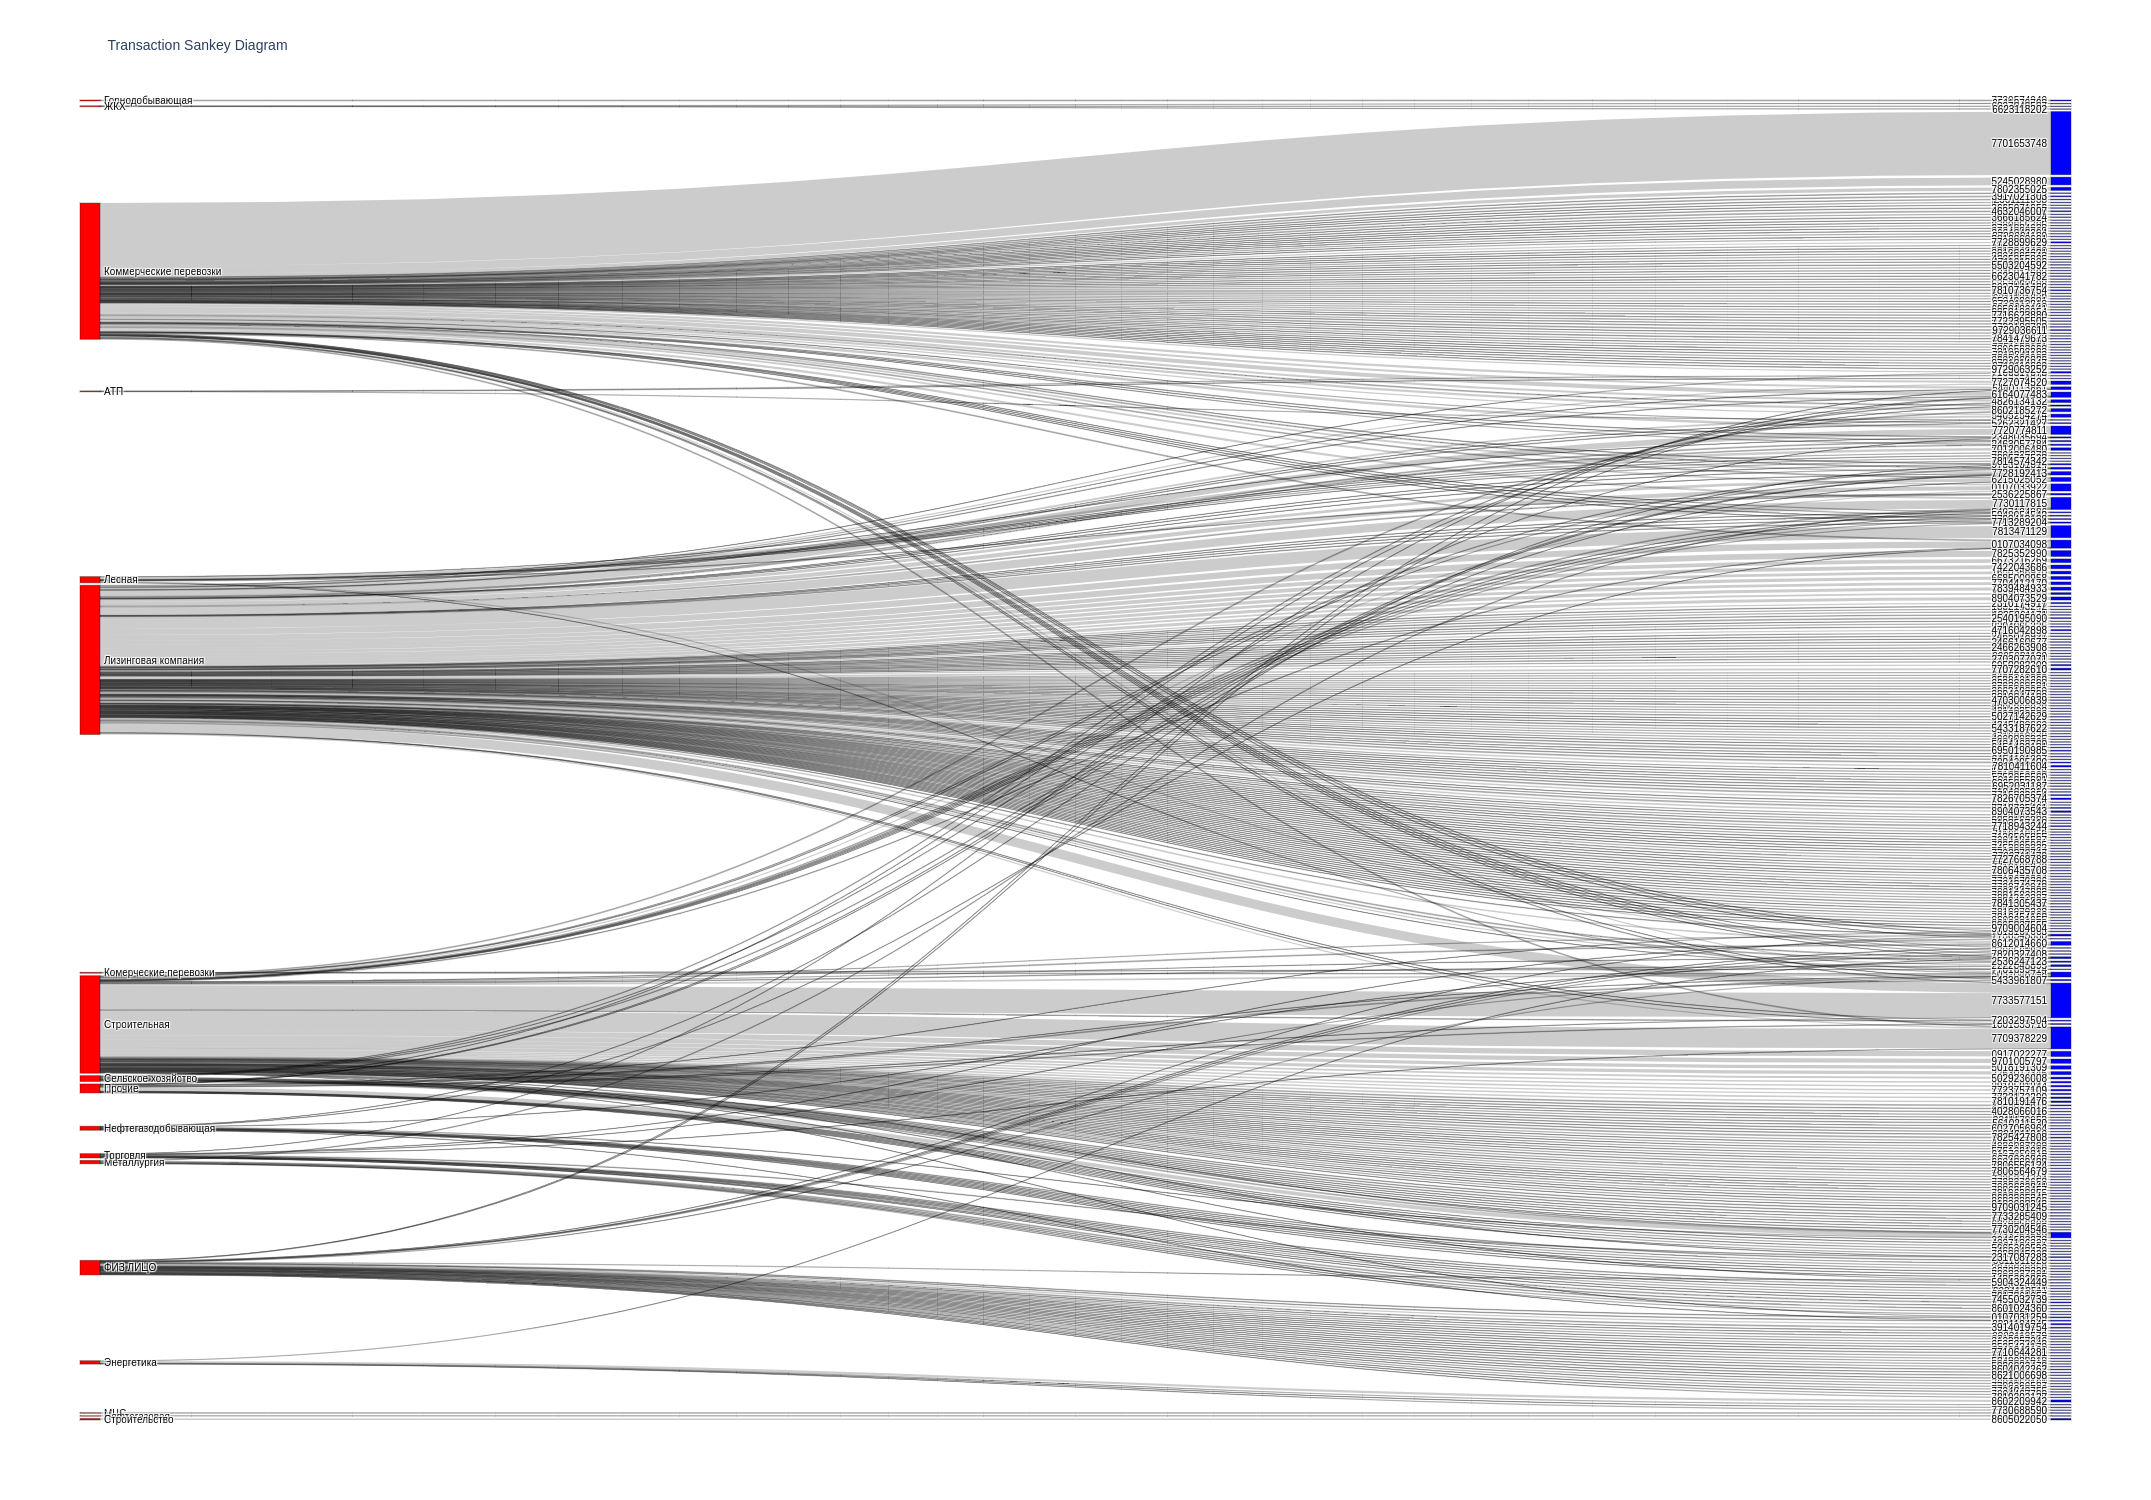

In [256]:
tmp = dataframe_select(
    transaction_data, 
        [
            seller_select,
            buyer_select,
            vehicle_select,
            transaction_select
        ])

display(tmp)
sankey_2(
    tmp,
    seller=seller_group,
    buyer=inn_group,
)

# STASH

In [75]:
!pwd ~/remote_shared_data/dsdiag222/gibdd_dataset_raw/

/home/jovyan/shared_data/truck_park/notebooks


In [ ]:
Тип двигателя
Экология

# UTILS

In [114]:
def dataframe_select(df, queries):
    df = df.copy()
    for query in queries:
        for key, values in query.items():
            df = df.loc[df[key].isin(values)]
    return df.reset_index(drop=True)

In [204]:
def sankey_2(transaction_df, seller='inn_seller', buyer='inn_buyer', w=1_000, h=1_500):
    
    transaction_df = transaction_df.copy()
    transaction_df['values'] = 1
    tmp = transaction_df.groupby([seller, buyer])['values'].count().reset_index()
    
    seller_list = tmp[seller].unique()
    buyer_list = tmp[buyer].unique()
    
    label = np.concatenate((seller_list, buyer_list))
    
    seller_dict = {inn: i for i, inn in enumerate(seller_list)}
    buyer_dict = {inn: i+len(seller_dict) for i, inn in enumerate(buyer_list)}
    
    color = ['red' for inn in seller_list] + ['blue' for inn in buyer_list]
    
    source = tmp[seller].apply(lambda x: seller_dict[x]).tolist()
    target = tmp[buyer].apply(lambda x: buyer_dict[x]).tolist()
    value = tmp['values'].values

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.2),
          label = np.concatenate((seller_list, buyer_list)),
          color = color,
        ),
        link = dict(
          source = source,
          target = target,
          value = value,
      ))])

    fig.update_layout(title_text="Transaction Sankey Diagram", font_size=10)
    fig.update_layout(
        autosize=True,
        width=w,
        height=h,)
    
    return fig

In [ ]:
#     tmp = transaction_df.groupby(['inn_seller', 'inn_buyer']).agg({
#         'brand': Counter,
#         'chassis_config': Counter,
#         'body_type': Counter,
#         'values': 'count',
#     }).reset_index()

In [187]:
def select_mult_w(df, column):
    values = df[column].unique()
    w = widgets.SelectMultiple(
        options=values,
        rows=min(10, len(values)),
        description=column,
        disabled=False
    )
    return w

In [191]:
interact(lambda x: x, select_mult_w(transaction_data, 'brand'))

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [190]:
from ipywidgets import interact

In [195]:
import ipywidgets as widgets

class SelectMultipleInteract(widgets.HBox):

    def __init__(self, df, columns):
        
        self.selectors = []
        for col in columns:
            self.selectors.append(select_mult_w(df, col))           
        
        super().__init__(children=self.selectors)
        self._set_observes()

    def _set_observes(self):
        for widg in self.selectors:
            widg.observe(self._observed_function, names='value')

    def _observed_function(self, widg):
        for widg in self.selectors:
            print(widg.description)
            print(widg.get_interact_value())

SelectMultipleInteract(transaction_data, ['brand', 'model'])

SelectMultipleInteract(children=(SelectMultiple(description='brand', options=('КАМАЗ', 'DAF', 'IVECO', 'MAN', …